In [79]:
# import module libraries
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

In [80]:
# LSTM with layer normalization
class LayerNormLSTM(nn.Module):
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node

        self.w_x = nn.Linear(input_node, 4*hidden_node, bias=False)
        self.w_h = nn.Linear(hidden_node, 4*hidden_node, bias=False)
        self.ln = nn.LayerNorm(4 * hidden_node)
        self.ln_c = nn.LayerNorm(hidden_node)

    def forward(self, x, hx):
        h, c = hx

        gates = self.w_x(x) + self.w_h(h)
        gates = self.ln(gates)

        i, f, g, o = gates.chunk(4, dim=1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)

        c_new = f * c + i * g
        c_new = self.ln_c(c_new)
        h_new = o * torch.tanh(c_new)

        return h_new, c_new

In [81]:
# State feature extractor using LayerNorm LSTM
class StateExtr(nn.Module):
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()
        self.hidden_node = hidden_node
        self.n_layer = n_layer
        self.input_node = input_node

        self.lstm_cells = nn.ModuleList()
        self.lstm_cells.append(LayerNormLSTM(input_node, hidden_node))

        for i in range(n_layer - 1):
            self.lstm_cells.append(LayerNormLSTM(hidden_node, hidden_node))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, seq_len):
        batch_size, max_len, _ = x.size()
        device = x.device

        h_states = []
        c_states = []

        for _ in range(self.n_layer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))

        outputs = []
        for t in range(max_len):
            x_t = x[:, t, :]

            layer_input = x_t # initialize layer input with input tensor
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))
                
                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new

                if layer_idx < len(self.lstm_cells) - 1:
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new

            outputs.append(layer_input)

        output_tensor = torch.stack(outputs, dim=1)
        seq_len_cpu = seq_len.detach().cpu().long()
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)

        masked_output = output_tensor * mask
        return self.dropout(masked_output)

In [82]:
# Physical change regressor
class PhysRegr(nn.Module):
    def __init__(self, input_node, output_node, n_layer, hidden_node, dropout):
        super().__init__()

        layers = []

        layers.extend([
            nn.Linear(input_node, hidden_node),
            nn.ReLU(),
            nn.Dropout(dropout)
        ])

        for _ in range(n_layer - 1):
            layers.extend([
                nn.Linear(hidden_node, hidden_node),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        
        layers.append(nn.Linear(hidden_node, output_node))
        layers.append(nn.Sigmoid())

        self.layers = nn.Sequential(*layers)

    def forward(self, hidden_states):
        return self.layers(hidden_states)

In [83]:
# Current regressor
class CurrRegr(nn.Module):
    def __init__(self, input_node, hidden_node, n_layer, dropout):
        super().__init__()

        layers = []

        layers.extend([
            nn.Linear(input_node, hidden_node),
            nn.ReLU(),
            nn.Dropout(dropout)
        ])

        for _ in range(n_layer - 1):
            layers.extend([
                nn.Linear(hidden_node, hidden_node),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
        
        layers.append(nn.Linear(hidden_node, 1))

        self.layers = nn.Sequential(*layers)

    def forward(self, hidden_states):
        return self.layers(hidden_states)

In [84]:
# Physical Constraint Layer
class PhysConstr(nn.Module):
    def __init__(self, range_mm, curr_regr, eps=1e-2):
        super().__init__()
        
        self.eps = eps
        self.curr_regr = curr_regr
        self.register_buffer('range_mm_tensor',self._range2tensor(range_mm))

    def _range2tensor(self, range_mm):
        feature_names = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
        ranges = torch.zeros(len(feature_names), 2)

        for i, name in enumerate(feature_names):
            ranges[i, 0] = range_mm[name]['min']
            ranges[i, 1] = range_mm[name]['max']

        return ranges

    def _norm_tensor(self, data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return (data - min_val) / (max_val - min_val)

    def _denorm_tensor(self, norm_data, feature_idx):
        min_val = self.range_mm_tensor[feature_idx, 0]
        max_val = self.range_mm_tensor[feature_idx, 1]
        return norm_data * (max_val - min_val) + min_val

    def forward(self, phys_chng, cur_state, fin, initV):
        V_idx, E_idx, VF_idx, VA_idx, VB_idx = 0, 1, 2, 3, 4
        CFLA_idx, CALA_idx, CFK_idx, CBK_idx, I_idx = 5, 6, 7, 8, 9

        VF = self._denorm_tensor(cur_state[..., 2:3], VF_idx)
        VA = self._denorm_tensor(cur_state[..., 3:4], VA_idx)
        VB = self._denorm_tensor(cur_state[..., 4:5], VB_idx)
        CFLA = self._denorm_tensor(cur_state[..., 5:6], CFLA_idx)
        CALA = self._denorm_tensor(cur_state[..., 6:7], CALA_idx)
        CFK = self._denorm_tensor(cur_state[..., 7:8], CFK_idx)
        CBK = self._denorm_tensor(cur_state[..., 8:9], CBK_idx)

        ## Flow in parameters
        FvF, FvA, FvB, CFLA_in, CALA_in, CFK_in, CBK_in = fin

        VFi, VAi, VBi = initV

        dVF_in, dVA_in, dVB_in = FvF, FvA, FvB
        dNFLA_in, dNALA_in, dNFK_in, dNBK_in = FvF * CFLA_in, FvA * CALA_in, FvF * CFK_in, FvB * CBK_in

        rdVA = phys_chng[..., 0:1]
        rdVB = phys_chng[..., 1:2]
        rdNALA = phys_chng[..., 2:3]
        rdNBK = phys_chng[..., 3:4]

        ## Mass Balance
        NFLA = CFLA * VF
        NALA = CALA * VA
        NFK = CFK * VF
        NBK = CBK * VB

### ===== 핵심 변경: Feed 먼저 추가 ===== ###
        # Step 1: Add feed streams
        VF_after_feed = VF + dVF_in
        VA_after_feed = VA + dVA_in
        VB_after_feed = VB + dVB_in
        NFLA_after_feed = NFLA + dNFLA_in
        NALA_after_feed = NALA  # No feed to acid
        NFK_after_feed = NFK + dNFK_in
        NBK_after_feed = NBK    # No feed to base

        # Step 2: Calculate separation based on feed-added state
        dVA = VF_after_feed * (rdVA - 0.5)
        dVB = VF_after_feed * (rdVB - 0.5)
        dNALA = NFLA_after_feed * rdNALA
        dNBK = NFK_after_feed * rdNBK

        ### Step 3: Calculate state after separation (before discharge)
        nVF_bf = VF_after_feed - dVA - dVB
        nVA_bf = VA_after_feed + dVA
        nVB_bf = VB_after_feed + dVB

        nNFLA_bf = NFLA_after_feed - dNALA
        nNALA_bf = NALA_after_feed + dNALA
        nNFK_bf = NFK_after_feed - dNBK
        nNBK_bf = NBK_after_feed + dNBK

        nCFLA = nNFLA_bf / nVF_bf
        nCALA = nNALA_bf / nVA_bf
        nCFK = nNFK_bf / nVF_bf
        nCBK = nNBK_bf / nVB_bf

        dVF_out = nVF_bf - VFi
        dVA_out = nVA_bf - VAi
        dVB_out = nVB_bf - VBi

        nVF = torch.where(dVF_out > 0, nVF_bf - dVF_out, nVF_bf)
        nVA = torch.where(dVA_out > 0, nVA_bf - dVA_out, nVA_bf)
        nVB = torch.where(dVB_out > 0, nVB_bf - dVB_out, nVB_bf)
        
        # dVF_out ~ dVB_out이 0보다 작으면 해당 영역 변수들이 0이 되도록 처리
        dNFLA_out = torch.where(dVF_out > 0, nCFLA * dVF_out, torch.zeros_like(dVF_out))
        dNFK_out = torch.where(dVF_out > 0, nCFK * dVF_out, torch.zeros_like(dVF_out))

        dNALA_out = torch.where(dVA_out > 0, nCALA * dVA_out, torch.zeros_like(dVA_out))
        dNBK_out = torch.where(dVB_out > 0, nCBK * dVB_out, torch.zeros_like(dVB_out))

        ### Final new states
        nNFLA = nNFLA_bf - dNFLA_out
        nNALA = nNALA_bf - dNALA_out
        nNFK = nNFK_bf - dNFK_out
        nNBK = nNBK_bf - dNBK_out

        V = cur_state[..., 0:1]
        E = cur_state[..., 1:2]

        nVF_norm = self._norm_tensor(nVF, VF_idx)
        nVA_norm = self._norm_tensor(nVA, VA_idx)
        nVB_norm = self._norm_tensor(nVB, VB_idx)
        nCFLA_norm = self._norm_tensor(nCFLA, CFLA_idx)
        nCALA_norm = self._norm_tensor(nCALA, CALA_idx)
        nCFK_norm = self._norm_tensor(nCFK, CFK_idx)
        nCBK_norm = self._norm_tensor(nCBK, CBK_idx)

        temp_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm
        ], dim=-1)

        nI_pred = self.curr_regr(temp_state)
        nI_real = self._denorm_tensor(nI_pred, I_idx)
        nI_real = torch.clamp(nI_real, min=0.0)
        nI_norm = self._norm_tensor(nI_real, I_idx)

        next_state = torch.cat([
            V, E, nVF_norm, nVA_norm, nVB_norm, nCFLA_norm, nCALA_norm, nCFK_norm, nCBK_norm, nI_norm
        ], dim=-1)

        ### discharge
        discharge = {
            'VF': dVF_out,
            'VA': dVA_out,
            'VB': dVB_out,
            'NFLA': dNFLA_out,
            'NALA': dNALA_out,
            'NFK': dNFK_out,
            'NBK': dNBK_out,
            'CFLA': nCFLA,
            'CALA': nCALA,
            'CFK': nCFK,
            'CBK': nCBK
        }

        discharge_list = [dVF_out[...,0].item(), dVA_out[...,0].item(), dVB_out[...,0].item(), nCFLA[...,0].item(), nCALA[...,0].item(), nCFK[...,0].item(), nCBK[...,0].item()]

        return next_state, discharge, discharge_list

In [85]:
# BMED model
class BMEDModel(nn.Module):
    def __init__(self, state_extr_params, phys_regr_params, curr_regr_params, range_mm):
        super().__init__()
        self.state_extr = StateExtr(**state_extr_params)
        self.phys_regr = PhysRegr(**phys_regr_params)
        self.curr_regr = CurrRegr(**curr_regr_params)
        self.phys_constr = PhysConstr(range_mm, self.curr_regr)

    def _init_hidden_states(self, batch_size, device):
        hidden_states = []
        cell_states =[]

        for _ in range(self.state_extr.n_layer):
            hidden_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))
            cell_states.append(torch.zeros(batch_size, self.state_extr.hidden_node, device=device))

        return {'hidden': hidden_states, 'cell': cell_states}

    def _input_stage1(self, fresh_feed, stage2_discharge):
        QF_fresh, CFLA_fresh, CFK_fresh = fresh_feed

        if stage2_discharge is not None:
            VA_from_s2 = stage2_discharge[1]
            VB_from_s2 = stage2_discharge[2]
            CALA_from_s2 = stage2_discharge[4]
            CBK_from_s2 = stage2_discharge[6]
        else:
            VA_from_s2 = VB_from_s2 = 0
            CALA_from_s2 = CBK_from_s2 = 0
        
        return [QF_fresh, VA_from_s2, VB_from_s2, CFLA_fresh, CALA_from_s2, CFK_fresh, CBK_from_s2]
    
    def _input_stage2(self, stage1_discharge, fresh_water):
        QA_fresh, QB_fresh = fresh_water

        if stage1_discharge is not None:
            VF_from_s1 = stage1_discharge[0]
            CFLA_from_s1 = stage1_discharge[3]
            CFK_from_s1 = stage1_discharge[5]
        else:
            VF_from_s1 = 0
            CFLA_from_s1 = CFK_from_s1 = 0

        return [VF_from_s1, QA_fresh, QB_fresh, CFLA_from_s1, 0, CFK_from_s1, 0]
    
    def _check_convergence(self, discharge_1, discharge_2, prev_1, prev_2, tolerance):
        if prev_1 is None or prev_2 is None:
            return False
        
        current_1 = torch.tensor([discharge_1['VF'].item(), discharge_1['VA'].item(), discharge_1['VB'].item(), discharge_1['CFLA'].item(), discharge_1['CALA'].item(), discharge_1['CFK'].item(), discharge_1['CBK'].item()])
        current_2 = torch.tensor([discharge_2['VF'].item(), discharge_2['VA'].item(), discharge_2['VB'].item(), discharge_2['CFLA'].item(), discharge_2['CALA'].item(), discharge_2['CFK'].item(), discharge_2['CBK'].item()])

        prev_1_tensor = torch.tensor(prev_1)
        prev_2_tensor = torch.tensor(prev_2)

        # 상대 변화량으로 수정 (0으로 나누기 방지)
        rel_change_1 = torch.abs((current_1 - prev_1_tensor) / (torch.abs(prev_1_tensor) + 1e-8))
        rel_change_2 = torch.abs((current_2 - prev_2_tensor) / (torch.abs(prev_2_tensor) + 1e-8))

        max_change = max(torch.max(rel_change_1), torch.max(rel_change_2))
        return max_change.item() < tolerance

    def _apply_relaxation(self, old_discharge, new_discharge, relaxation_factor):
        if old_discharge is None:
            return [new_discharge['VF'].item(), new_discharge['VA'].item(), new_discharge['VB'].item(), new_discharge['CFLA'].item(), new_discharge['CALA'].item(), new_discharge['CFK'].item(), new_discharge['CBK'].item()]

        new_values = [new_discharge['VF'].item(), new_discharge['VA'].item(), new_discharge['VB'].item(), new_discharge['CFLA'].item(), new_discharge['CALA'].item(), new_discharge['CFK'].item(), new_discharge['CBK'].item()]

        relaxed = []
        for old_val, new_val in zip(old_discharge, new_values):
            relaxed_val = old_val + relaxation_factor * (new_val - old_val)
            relaxed.append(relaxed_val)

        return relaxed


    def cont_sim(self, init_state_1, init_state_2, target_len, fresh_feed, fresh_water, initV, tolerance, max_iter, relaxation):
        batch_size_1 = init_state_1.size(0)
        feature_size_1 = init_state_1.size(1)
        device_1 = init_state_1.device

        batch_size_2 = init_state_2.size(0)
        feature_size_2 = init_state_2.size(1)
        device_2 = init_state_2.device
        
        state1_states = self._init_hidden_states(batch_size_1, device_1)
        state2_states = self._init_hidden_states(batch_size_2, device_2)

        pred1 = torch.zeros(batch_size_1, target_len, feature_size_1, device=device_1)
        pred2 = torch.zeros(batch_size_2, target_len, feature_size_2, device=device_2)

        discharge_record_1 = []
        discharge_record_2 = []
        convergence_info = []

        stage1_discharge_prev= None
        stage2_discharge_prev = None

        cur_state_1 = init_state_1.clone()
        cur_state_2 = init_state_2.clone()

        for t in range(target_len):
            pred1[:, t, :] = cur_state_1
            pred2[:, t, :] = cur_state_2

            if t < target_len - 1:
                lstm_input_1 = cur_state_1[:, :-1] # except current
                lstm_input_2 = cur_state_2[:, :-1] # except current

                hidden_output_1 = self._lstm_single_step(lstm_input_1, state1_states)
                hidden_output_2 = self._lstm_single_step(lstm_input_2, state2_states)

                phys_chng_1 = self.phys_regr(hidden_output_1.unsqueeze(1))
                phys_chng_2 = self.phys_regr(hidden_output_2.unsqueeze(1))
                cur_state_expanded_1 = cur_state_1.unsqueeze(1)
                cur_state_expanded_2 = cur_state_2.unsqueeze(1)

                converged = False
                iteration = 0

                while not converged and iteration < max_iter:
                    fin_1_coupled = self._input_stage1(fresh_feed, stage2_discharge_prev)
                    fin_2_coupled = self._input_stage2(stage1_discharge_prev, fresh_water)

                    next_state_1, discharge_1, _ = self.phys_constr(
                        phys_chng_1, cur_state_expanded_1, fin_1_coupled, initV
                    )
                    
                    next_state_2, discharge_2, _ = self.phys_constr(
                        phys_chng_2, cur_state_expanded_2, fin_2_coupled, initV
                    )
                    
                    # 수렴 체크 추가
                    converged = self._check_convergence(discharge_1, discharge_2, stage1_discharge_prev, stage2_discharge_prev, tolerance)
                    
                    if not converged:
                        stage1_discharge_prev= self._apply_relaxation(stage1_discharge_prev, discharge_1, relaxation)
                        stage2_discharge_prev = self._apply_relaxation(stage2_discharge_prev, discharge_2, relaxation)

                    iteration += 1
                
                convergence_info.append({
                    'time_step': t,
                    'iteration': iteration,
                    'converged': converged
                })

                cur_state_1 = next_state_1.squeeze(1)
                cur_state_2 = next_state_2.squeeze(1)
                discharge_record_1.append(discharge_1)
                discharge_record_2.append(discharge_2)

        return pred1, pred2, discharge_record_1, discharge_record_2, convergence_info

    def _lstm_single_step(self, x_t, stage_states):
        layer_input = x_t
        hidden_states = stage_states['hidden']
        cell_states = stage_states['cell']

        for layer_idx, lstm_cell in enumerate(self.state_extr.lstm_cells):
            h_new, c_new = lstm_cell(layer_input, (hidden_states[layer_idx], cell_states[layer_idx]))
            
            hidden_states[layer_idx] = h_new
            cell_states[layer_idx] = c_new

            if layer_idx < len(self.state_extr.lstm_cells) - 1:
                layer_input = self.state_extr.dropout(h_new)
            else:
                layer_input = h_new # last layer output

        return self.state_extr.dropout(layer_input)

    def forward(self, init_state_1, init_state_2, target_len, fresh_feed, fresh_water, initV, tolerance, max_iter, relaxation):
        return self.cont_sim(init_state_1, init_state_2, target_len, fresh_feed, fresh_water, initV, tolerance, max_iter, relaxation)

In [86]:
# Utility functions

## Normalize input data with the min-max normalization range of pre-trained model
def normalize(inputs, range_mm):
    features = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK']
    norm = []

    for _, (name, value) in enumerate(zip(features, inputs)):
        min_val = range_mm[name]['min']
        max_val = range_mm[name]['max']
        norm_val = (value - min_val) / (max_val - min_val)
        norm.append(norm_val)
    
    return norm

def denormalize(outputs, range_mm):
    """출력값들을 실제 물리적 값으로 변환"""
    feature_names = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    denormalized = np.zeros_like(outputs)
    
    for i, name in enumerate(feature_names):
        if name in range_mm:
            min_val = range_mm[name]['min']
            max_val = range_mm[name]['max']
            denormalized[:, :, i] = outputs[:, :, i] * (max_val - min_val) + min_val
        else:
            denormalized[:, :, i] = outputs[:, :, i]
    
    return denormalized

In [87]:
# Load trained model
model_path = 'BMED_FR_251010.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Model: {model_path}')
print(f'Device: {device}')

model = torch.load(model_path, map_location=device, weights_only=False)
model_config = model['model_config']
state_extr_params = model_config['state_extr_params']
phys_regr_params = model_config['phys_regr_params']
curr_regr_params = model_config['curr_regr_params']
model_range_mm = model_config['range_mm']

simulator = BMEDModel(
    state_extr_params = state_extr_params,
    phys_regr_params = phys_regr_params,
    curr_regr_params = curr_regr_params,
    range_mm = model_range_mm
).to(device)

simulator.load_state_dict(model['model_state_dict'])
simulator.eval()

print('Load model parameters')

Model: BMED_FR_251010.pth
Device: cuda
Load model parameters


In [88]:
# 2-Stage Countercurrent BMED Simulation Conditions

# Stage 1 initial conditions
V1 = 23  # Stage 1 Voltage (V)
E1 = 0.8  # Stage 1 Electrolyte concentration (mol/L)

# Stage 2 initial conditions
V2 = 15  # Stage 2 Voltage (V)
E2 = 0.3  # Stage 2 Electrolyte concentration (mol/L)

# Feed conditions
CFLA = 1.4  # Feed LA concentration (mol/L)
QF = 14.5  # Feed flow rate (mL/min)
QA = 14.5  # Acid recycle flow rate (mL/min)
QB = 14.5  # Base recycle flow rate (mL/min)

# Simulation settings
simulation_time = 200  # time steps to simulate
tolerance = 1e-4  # Convergence tolerance for stage coupling
max_iter = 100  # Maximum iterations for convergence
relaxation = 0.7  # Relaxation factor for convergence

# Initial conditions
cond_init1 = [V1, E1, 0.7, 0.7, 0.7, CFLA, 0, CFLA*2, 0]  # Stage 1 initial state
cond_init2 = [V2, E2, 0.7, 0.7, 0.7, CFLA, 0, CFLA*2, 0]  # Stage 2 initial state

# Flow conditions (L/step, 1 step = 0.25 hr)
fresh_feed = [QF*60/1000*0.25, CFLA, CFLA*2]  # [QF, CFLA, CFK]
fresh_water = [QA*60/1000*0.25, QB*60/1000*0.25]  # [QA, QB]

# Overflooding volumes
initV = [0.7, 0.7, 0.7]  # [VF, VA, VB] in L

# Normalize inputs
norm_inputs_1 = normalize(cond_init1, model_range_mm)
norm_inputs_2 = normalize(cond_init2, model_range_mm)

init_normI = 0.0
init_state_values_1 = norm_inputs_1 + [init_normI]
init_state_values_2 = norm_inputs_2 + [init_normI]
init_state_tensor_1 = torch.tensor([init_state_values_1]).float().to(device)
init_state_tensor_2 = torch.tensor([init_state_values_2]).float().to(device)

print('=== 2-Stage Countercurrent BMED Simulation Setup ===')
print(f'\nStage 1 Conditions:')
print(f'   - Voltage: {V1}V, Electrolyte: {E1}M')
print(f'   - Overflooding: VF={cond_init1[2]}L, VA={cond_init1[3]}L, VB={cond_init1[4]}L')
print(f'\nStage 2 Conditions:')
print(f'   - Voltage: {V2}V, Electrolyte: {E2}M')
print(f'   - Overflooding: VF={cond_init2[2]}L, VA={cond_init2[3]}L, VB={cond_init2[4]}L')
print(f'\nFlow Conditions (Countercurrent Configuration):')
print(f'   - Fresh Feed: {QF} mL/min, LA={CFLA}M, K={CFLA*2}M')
print(f'   - Fresh Water: Acid={QA} mL/min, Base={QB} mL/min')
print(f'\nStage Coupling:')
print(f'   - Stage 1: Fresh feed + Stage 2 acid/base discharge')
print(f'   - Stage 2: Stage 1 feed discharge + Fresh water')
print(f'\nConvergence Settings:')
print(f'   - Tolerance: {tolerance}, Max iterations: {max_iter}, Relaxation: {relaxation}')

=== 2-Stage Countercurrent BMED Simulation Setup ===

Stage 1 Conditions:
   - Voltage: 23V, Electrolyte: 0.8M
   - Overflooding: VF=0.7L, VA=0.7L, VB=0.7L

Stage 2 Conditions:
   - Voltage: 15V, Electrolyte: 0.3M
   - Overflooding: VF=0.7L, VA=0.7L, VB=0.7L

Flow Conditions (Countercurrent Configuration):
   - Fresh Feed: 14.5 mL/min, LA=1.4M, K=2.8M
   - Fresh Water: Acid=14.5 mL/min, Base=14.5 mL/min

Stage Coupling:
   - Stage 1: Fresh feed + Stage 2 acid/base discharge
   - Stage 2: Stage 1 feed discharge + Fresh water

Convergence Settings:
   - Tolerance: 0.0001, Max iterations: 100, Relaxation: 0.7


In [89]:
# Run 2-Stage Countercurrent Simulation
print('Starting 2-Stage Countercurrent BMED Simulation...')

with torch.no_grad():
    pred1, pred2, discharge_record_1, discharge_record_2, convergence_info = simulator(
        init_state_tensor_1, init_state_tensor_2, simulation_time, 
        fresh_feed, fresh_water, initV, tolerance, max_iter, relaxation
    )

# Post processing
pred_norm_1 = pred1.cpu().numpy()
pred_norm_2 = pred2.cpu().numpy()
pred_real_1 = denormalize(pred_norm_1, model_range_mm)
pred_real_2 = denormalize(pred_norm_2, model_range_mm)

time_steps = np.arange(simulation_time)*0.25

print('\n2-Stage Countercurrent BMED Simulation Complete!')
print(f'\nConvergence Statistics:')
converged_count = sum(1 for info in convergence_info if info['converged'])
avg_iterations = np.mean([info['iteration'] for info in convergence_info])
print(f'   - Converged time steps: {converged_count}/{len(convergence_info)} ({converged_count/len(convergence_info)*100:.1f}%)')
print(f'   - Average iterations: {avg_iterations:.1f}')
print(f'   - Max iterations: {max([info["iteration"] for info in convergence_info])}')

Starting 2-Stage Countercurrent BMED Simulation...



2-Stage Countercurrent BMED Simulation Complete!

Convergence Statistics:
   - Converged time steps: 199/199 (100.0%)
   - Average iterations: 6.3
   - Max iterations: 10


In [90]:
# Process Results for Both Stages

# Stage 1 results
sim_res_1 = {
    'time': time_steps,
    'V': pred_real_1[0, :, 0],
    'E': pred_real_1[0, :, 1], 
    'VF': pred_real_1[0, :, 2],
    'VA': pred_real_1[0, :, 3],
    'VB': pred_real_1[0, :, 4],
    'CFLA': pred_real_1[0, :, 5],
    'CALA': pred_real_1[0, :, 6],
    'CFK': pred_real_1[0, :, 7],
    'CBK': pred_real_1[0, :, 8],
    'I': pred_real_1[0, :, 9]
}

discharge_data_1 = {
    'time': time_steps[:-1],
    'VF_out': [],
    'VA_out': [],
    'VB_out': [],
    'CFLA_out': [],
    'CALA_out': [],
    'CFK_out': [],
    'CBK_out': [],
    'NFLA_out': [],
    'NALA_out': [],  
    'NFK_out': [],
    'NBK_out': []
}

for discharge in discharge_record_1:
    discharge_data_1['VF_out'].append(discharge['VF'].item()/0.25)
    discharge_data_1['VA_out'].append(discharge['VA'].item()/0.25)
    discharge_data_1['VB_out'].append(discharge['VB'].item()/0.25)
    discharge_data_1['CFLA_out'].append(discharge['CFLA'].item())
    discharge_data_1['CALA_out'].append(discharge['CALA'].item())
    discharge_data_1['CFK_out'].append(discharge['CFK'].item())
    discharge_data_1['CBK_out'].append(discharge['CBK'].item())
    discharge_data_1['NFLA_out'].append(discharge['NFLA'].item()/0.25)
    discharge_data_1['NALA_out'].append(discharge['NALA'].item()/0.25)
    discharge_data_1['NFK_out'].append(discharge['NFK'].item()/0.25)
    discharge_data_1['NBK_out'].append(discharge['NBK'].item()/0.25)

# Stage 2 results
sim_res_2 = {
    'time': time_steps,
    'V': pred_real_2[0, :, 0],
    'E': pred_real_2[0, :, 1], 
    'VF': pred_real_2[0, :, 2],
    'VA': pred_real_2[0, :, 3],
    'VB': pred_real_2[0, :, 4],
    'CFLA': pred_real_2[0, :, 5],
    'CALA': pred_real_2[0, :, 6],
    'CFK': pred_real_2[0, :, 7],
    'CBK': pred_real_2[0, :, 8],
    'I': pred_real_2[0, :, 9]
}

discharge_data_2 = {
    'time': time_steps[:-1],
    'VF_out': [],
    'VA_out': [],
    'VB_out': [],   
    'CFLA_out': [],
    'CALA_out': [],
    'CFK_out': [],
    'CBK_out': [],
    'NFLA_out': [],
    'NALA_out': [],
    'NFK_out': [],
    'NBK_out': []
}

for discharge in discharge_record_2:
    discharge_data_2['VF_out'].append(discharge['VF'].item()/0.25)
    discharge_data_2['VA_out'].append(discharge['VA'].item()/0.25)
    discharge_data_2['VB_out'].append(discharge['VB'].item()/0.25)
    discharge_data_2['CFLA_out'].append(discharge['CFLA'].item())
    discharge_data_2['CALA_out'].append(discharge['CALA'].item())
    discharge_data_2['CFK_out'].append(discharge['CFK'].item())
    discharge_data_2['CBK_out'].append(discharge['CBK'].item())
    discharge_data_2['NFLA_out'].append(discharge['NFLA'].item()/0.25)
    discharge_data_2['NALA_out'].append(discharge['NALA'].item()/0.25)
    discharge_data_2['NFK_out'].append(discharge['NFK'].item()/0.25)
    discharge_data_2['NBK_out'].append(discharge['NBK'].item()/0.25)

# Calculate recovery efficiency
input_LA_rate = fresh_feed[0]/0.25 * fresh_feed[1]  # mol/hr
recovery_efficiency_s1 = np.array(discharge_data_1['NALA_out'])/input_LA_rate * 100
recovery_efficiency_s2 = np.array(discharge_data_2['NALA_out'])/input_LA_rate * 100
total_recovery = recovery_efficiency_s1 + recovery_efficiency_s2

print('Results processing complete.')

Results processing complete.


/tmp/ipykernel_45833/1926152534.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


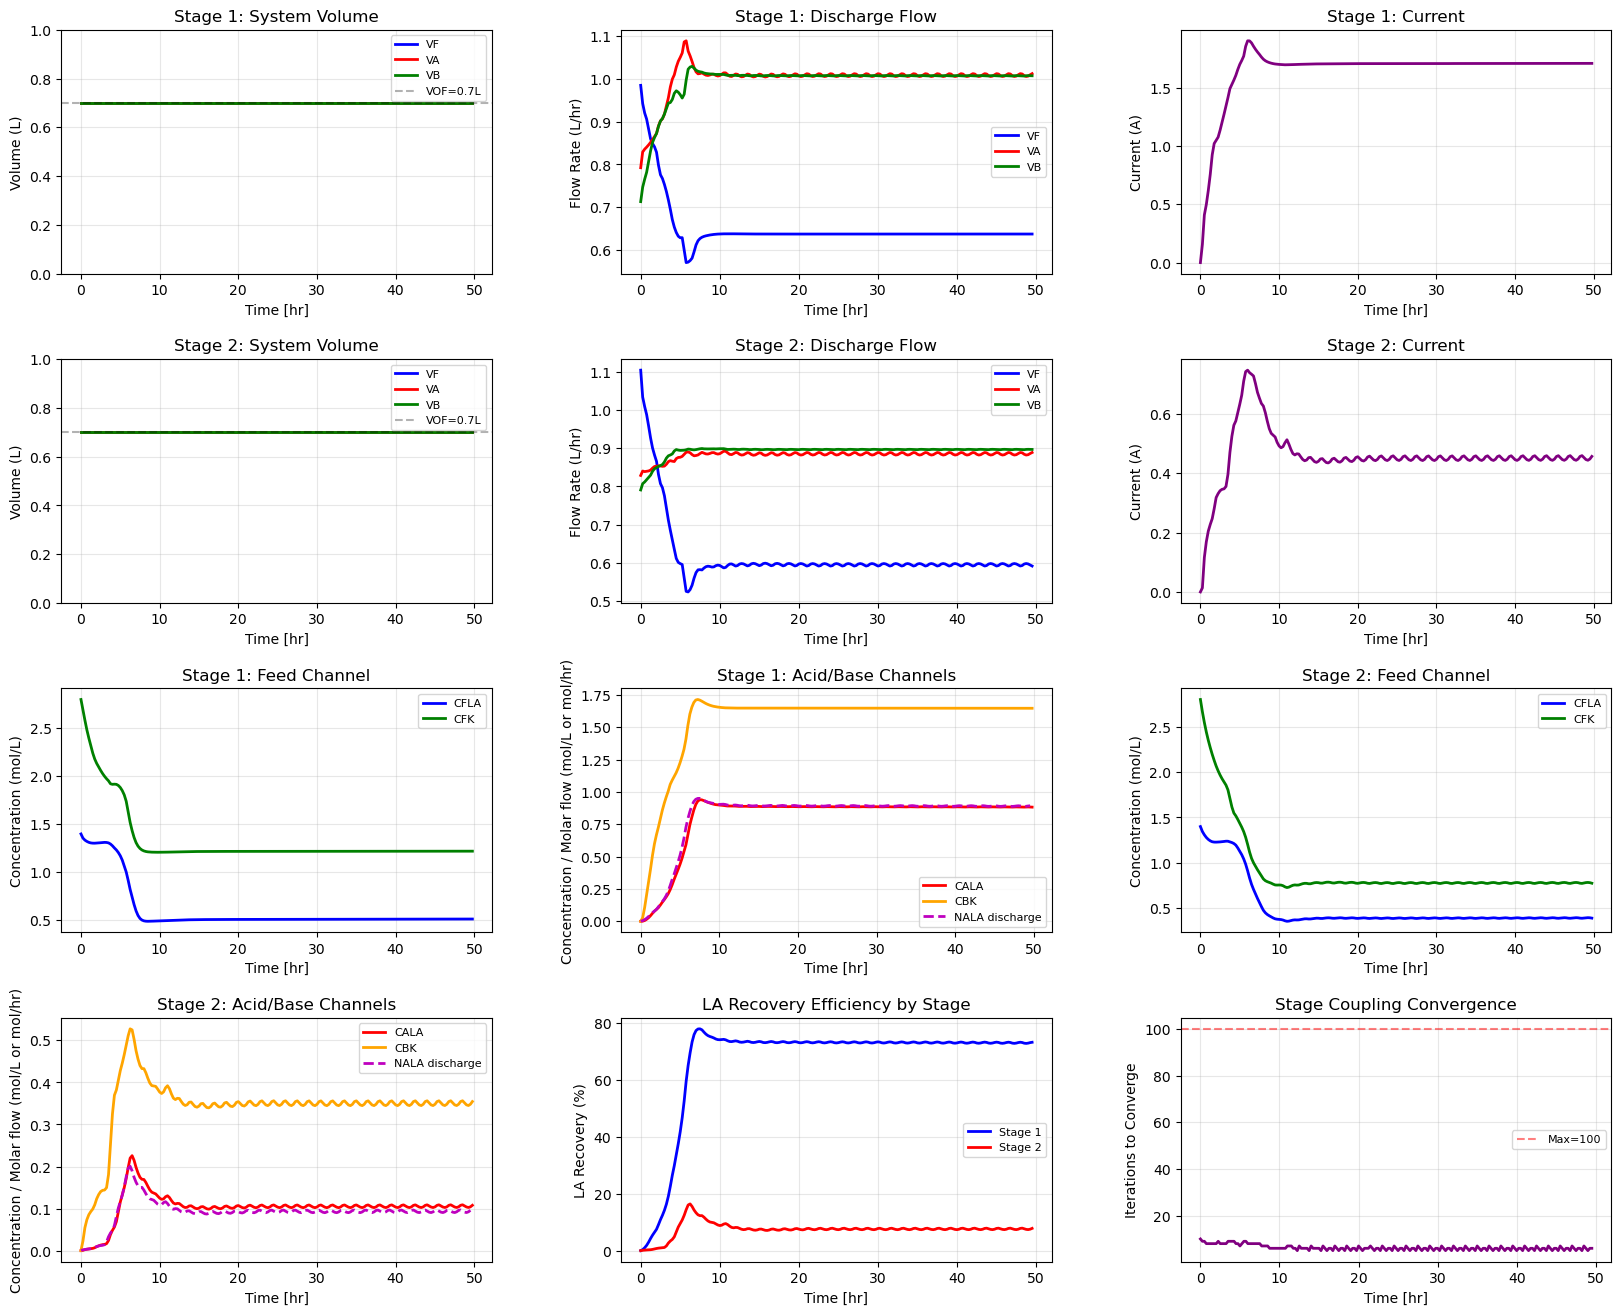

In [91]:
# Visualization: 2-Stage System Overview
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(4, 3, figure=fig, hspace=0.35, wspace=0.3)

# Stage 1 - System Volume
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(sim_res_1['time'], sim_res_1['VF'], 'b-', label='VF', linewidth=2)
ax1.plot(sim_res_1['time'], sim_res_1['VA'], 'r-', label='VA', linewidth=2)
ax1.plot(sim_res_1['time'], sim_res_1['VB'], 'g-', label='VB', linewidth=2)
ax1.axhline(y=0.7, color='k', linestyle='--', alpha=0.3, label='VOF=0.7L')
ax1.set_xlabel('Time [hr]')
ax1.set_ylabel('Volume (L)')
ax1.set_title('Stage 1: System Volume')
ax1.set_ylim([0,1])
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# Stage 1 - Discharge Flow
ax2 = fig.add_subplot(gs[0,1])
ax2.plot(discharge_data_1['time'], discharge_data_1['VF_out'], 'b-', label='VF', linewidth=2)
ax2.plot(discharge_data_1['time'], discharge_data_1['VA_out'], 'r-', label='VA', linewidth=2)
ax2.plot(discharge_data_1['time'], discharge_data_1['VB_out'], 'g-', label='VB', linewidth=2)
ax2.set_xlabel('Time [hr]')
ax2.set_ylabel('Flow Rate (L/hr)')
ax2.set_title('Stage 1: Discharge Flow')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# Stage 1 - Current
ax3 = fig.add_subplot(gs[0,2])
ax3.plot(sim_res_1['time'], sim_res_1['I'], 'purple', linewidth=2)
ax3.set_xlabel('Time [hr]')
ax3.set_ylabel('Current (A)')
ax3.set_title('Stage 1: Current')
ax3.grid(True, alpha=0.3)

# Stage 2 - System Volume
ax4 = fig.add_subplot(gs[1,0])
ax4.plot(sim_res_2['time'], sim_res_2['VF'], 'b-', label='VF', linewidth=2)
ax4.plot(sim_res_2['time'], sim_res_2['VA'], 'r-', label='VA', linewidth=2)
ax4.plot(sim_res_2['time'], sim_res_2['VB'], 'g-', label='VB', linewidth=2)
ax4.axhline(y=0.7, color='k', linestyle='--', alpha=0.3, label='VOF=0.7L')
ax4.set_xlabel('Time [hr]')
ax4.set_ylabel('Volume (L)')
ax4.set_title('Stage 2: System Volume')
ax4.set_ylim([0,1])
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

# Stage 2 - Discharge Flow
ax5 = fig.add_subplot(gs[1,1])
ax5.plot(discharge_data_2['time'], discharge_data_2['VF_out'], 'b-', label='VF', linewidth=2)
ax5.plot(discharge_data_2['time'], discharge_data_2['VA_out'], 'r-', label='VA', linewidth=2)
ax5.plot(discharge_data_2['time'], discharge_data_2['VB_out'], 'g-', label='VB', linewidth=2)
ax5.set_xlabel('Time [hr]')
ax5.set_ylabel('Flow Rate (L/hr)')
ax5.set_title('Stage 2: Discharge Flow')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

# Stage 2 - Current
ax6 = fig.add_subplot(gs[1,2])
ax6.plot(sim_res_2['time'], sim_res_2['I'], 'purple', linewidth=2)
ax6.set_xlabel('Time [hr]')
ax6.set_ylabel('Current (A)')
ax6.set_title('Stage 2: Current')
ax6.grid(True, alpha=0.3)

# Stage 1 - Feed Channel Concentrations
ax7 = fig.add_subplot(gs[2,0])
ax7.plot(sim_res_1['time'], sim_res_1['CFLA'], 'b-', label='CFLA', linewidth=2)
ax7.plot(sim_res_1['time'], sim_res_1['CFK'], 'g-', label='CFK', linewidth=2)
ax7.set_xlabel('Time [hr]')
ax7.set_ylabel('Concentration (mol/L)')
ax7.set_title('Stage 1: Feed Channel')
ax7.legend(fontsize=8)
ax7.grid(True, alpha=0.3)

# Stage 1 - Acid/Base Channels
ax8 = fig.add_subplot(gs[2,1])
ax8.plot(sim_res_1['time'], sim_res_1['CALA'], 'r-', label='CALA', linewidth=2)
ax8.plot(sim_res_1['time'], sim_res_1['CBK'], 'orange', label='CBK', linewidth=2)
ax8.plot(discharge_data_1['time'], discharge_data_1['NALA_out'], 'm--', label='NALA discharge', linewidth=2)
ax8.set_xlabel('Time [hr]')
ax8.set_ylabel('Concentration / Molar flow (mol/L or mol/hr)')
ax8.set_title('Stage 1: Acid/Base Channels')
ax8.legend(fontsize=8)
ax8.grid(True, alpha=0.3)

# Stage 2 - Feed Channel Concentrations
ax9 = fig.add_subplot(gs[2,2])
ax9.plot(sim_res_2['time'], sim_res_2['CFLA'], 'b-', label='CFLA', linewidth=2)
ax9.plot(sim_res_2['time'], sim_res_2['CFK'], 'g-', label='CFK', linewidth=2)
ax9.set_xlabel('Time [hr]')
ax9.set_ylabel('Concentration (mol/L)')
ax9.set_title('Stage 2: Feed Channel')
ax9.legend(fontsize=8)
ax9.grid(True, alpha=0.3)

# Stage 2 - Acid/Base Channels
ax10 = fig.add_subplot(gs[3,0])
ax10.plot(sim_res_2['time'], sim_res_2['CALA'], 'r-', label='CALA', linewidth=2)
ax10.plot(sim_res_2['time'], sim_res_2['CBK'], 'orange', label='CBK', linewidth=2)
ax10.plot(discharge_data_2['time'], discharge_data_2['NALA_out'], 'm--', label='NALA discharge', linewidth=2)
ax10.set_xlabel('Time [hr]')
ax10.set_ylabel('Concentration / Molar flow (mol/L or mol/hr)')
ax10.set_title('Stage 2: Acid/Base Channels')
ax10.legend(fontsize=8)
ax10.grid(True, alpha=0.3)

# Recovery Efficiency Comparison (no total line)
ax11 = fig.add_subplot(gs[3,1])
ax11.plot(discharge_data_1['time'], recovery_efficiency_s1, 'b-', label='Stage 1', linewidth=2)
ax11.plot(discharge_data_2['time'], recovery_efficiency_s2, 'r-', label='Stage 2', linewidth=2)
ax11.set_xlabel('Time [hr]')
ax11.set_ylabel('LA Recovery (%)')
ax11.set_title('LA Recovery Efficiency by Stage')
ax11.legend(fontsize=8)
ax11.grid(True, alpha=0.3)

# Convergence Information
ax12 = fig.add_subplot(gs[3,2])
iterations = [info['iteration'] for info in convergence_info]
ax12.plot(time_steps[:-1], iterations, 'purple', linewidth=2)
ax12.axhline(y=max_iter, color='r', linestyle='--', alpha=0.5, label=f'Max={max_iter}')
ax12.set_xlabel('Time [hr]')
ax12.set_ylabel('Iterations to Converge')
ax12.set_title('Stage Coupling Convergence')
ax12.legend(fontsize=8)
ax12.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [92]:
# Steady State Performance Analysis
ss_start, ss_end = 160, 180  # Steady state region (40-45 hr)

print('=== Steady State Analysis (40-45 hr) ===')
print('\n--- Stage 1 Performance ---')
I1_st = np.mean(sim_res_1['I'][ss_start:ss_end])
print(f'Average Current: {I1_st:.3f} A')
print(f'LA in Acid (NALA): {np.mean(discharge_data_1["NALA_out"][ss_start:ss_end]):.3f} mol/hr')
print(f'Recovery Efficiency: {np.mean(recovery_efficiency_s1[ss_start:ss_end]):.2f}%')

print('\n--- Stage 2 Performance ---')
I2_st = np.mean(sim_res_2['I'][ss_start:ss_end])
print(f'Average Current: {I2_st:.3f} A')
print(f'LA in Acid (NALA): {np.mean(discharge_data_2["NALA_out"][ss_start:ss_end]):.3f} mol/hr')
print(f'Recovery Efficiency: {np.mean(recovery_efficiency_s2[ss_start:ss_end]):.2f}%')

print('\n--- Overall System Performance ---')
total_LA_recovered = np.mean(discharge_data_1['NALA_out'][ss_start:ss_end]) + np.mean(discharge_data_2['NALA_out'][ss_start:ss_end])
total_recovery_eff = np.mean(total_recovery[ss_start:ss_end])
print(f'Total LA Recovered: {total_LA_recovered:.3f} mol/hr')
print(f'Total Recovery Efficiency: {total_recovery_eff:.2f}%')
print(f'LA Productivity: {total_LA_recovered * 90.1:.2f} g/hr')

# Energy consumption
total_power = V1 * I1_st + V2 * I2_st  # W
SEC = total_power / (total_LA_recovered * 90.1)  # kWh/kg
print(f'\nTotal Power: {total_power:.2f} W')
print(f'Specific Energy Consumption: {SEC:.3f} kWh/kg')

=== Steady State Analysis (40-45 hr) ===

--- Stage 1 Performance ---
Average Current: 1.707 A
LA in Acid (NALA): 0.891 mol/hr
Recovery Efficiency: 73.15%

--- Stage 2 Performance ---
Average Current: 0.450 A
LA in Acid (NALA): 0.093 mol/hr
Recovery Efficiency: 7.65%

--- Overall System Performance ---
Total LA Recovered: 0.984 mol/hr
Total Recovery Efficiency: 80.80%
LA Productivity: 88.67 g/hr

Total Power: 46.01 W
Specific Energy Consumption: 0.519 kWh/kg



=== 2-Stage Countercurrent Mass Balance Verification ===

=== Total System Input Rates ===
H2O input: 145.000 mol/hr
LA input: 1.218 mol/hr
K input: 2.436 mol/hr

=== Steady State Mass Balance (40-45hr) ===
H2O balance error: -45.480 ± 0.176 %
LA balance error: 19.200 ± 0.298 %
K balance error: 19.053 ± 0.133 %


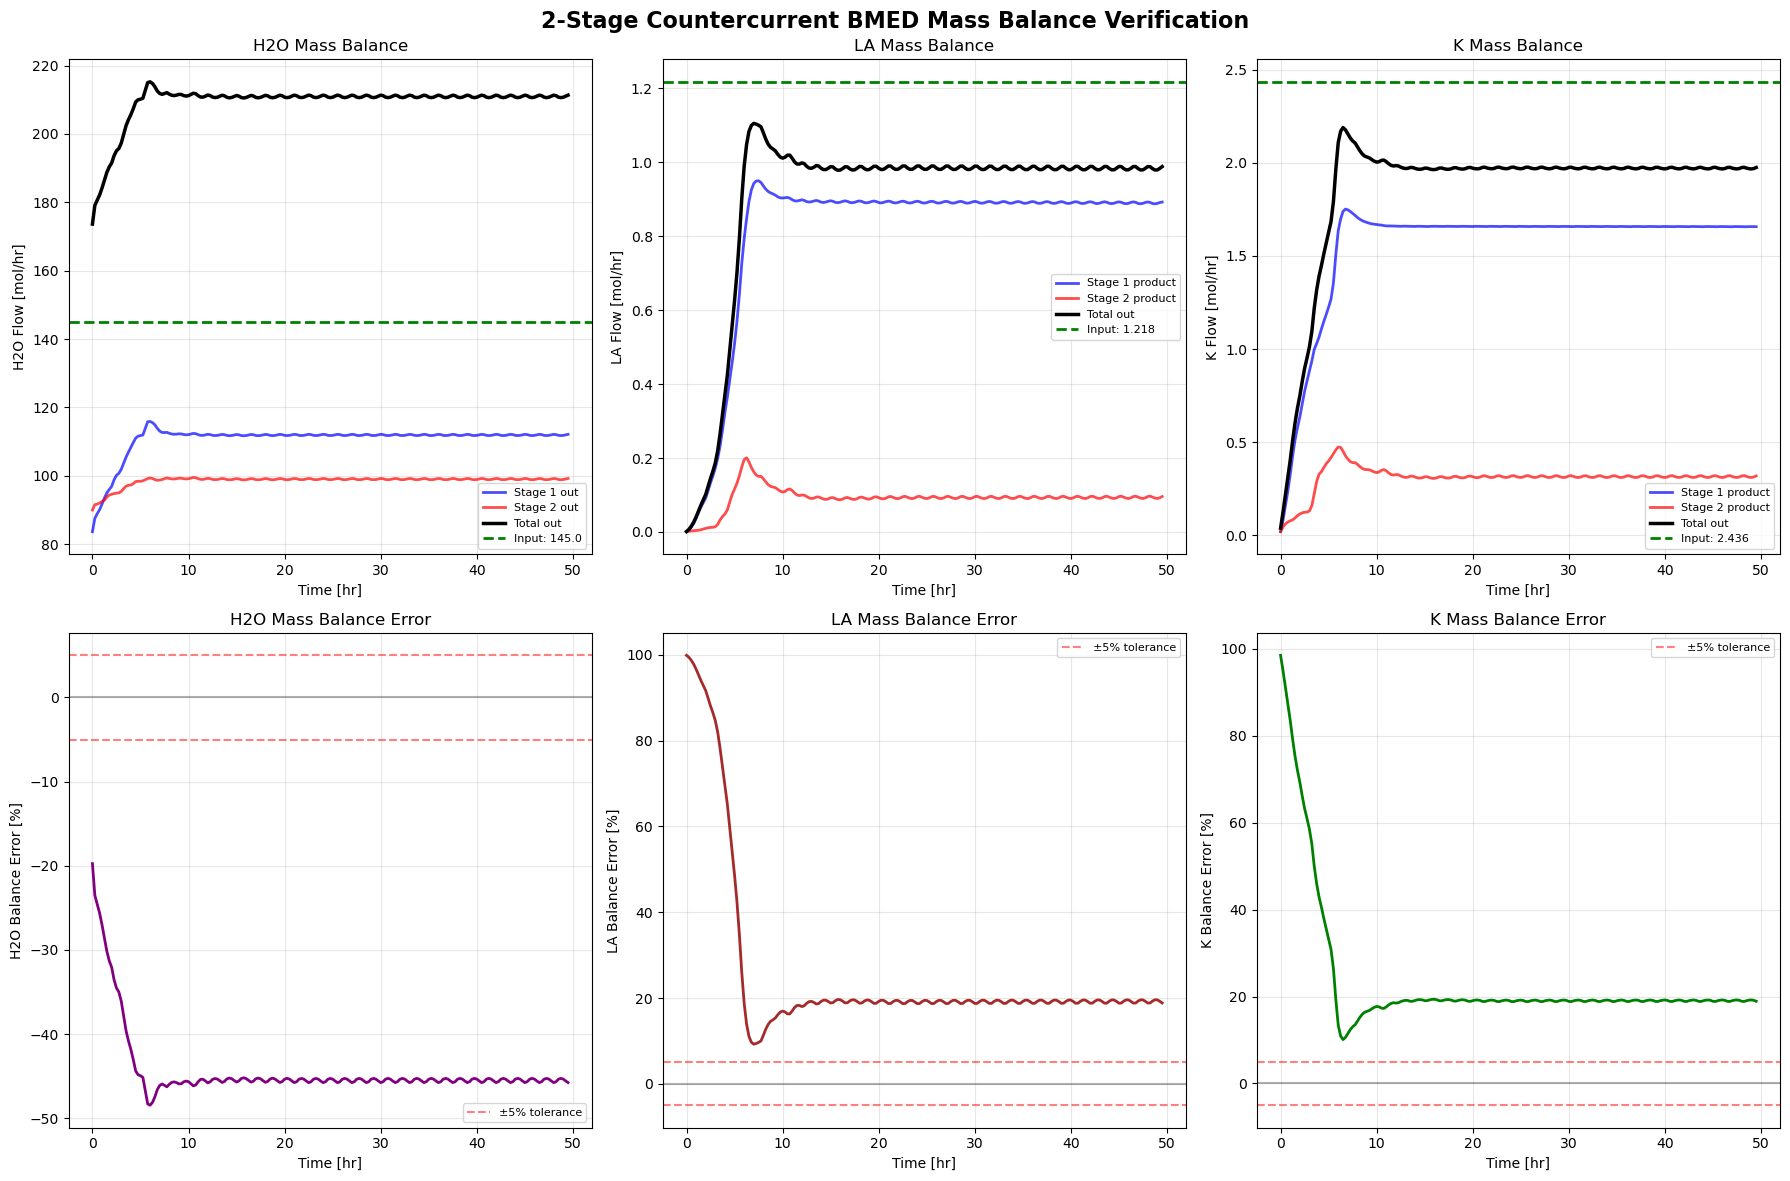


=== Separation Efficiency Analysis (Steady State) ===
LA Recovery - Stage 1: 90.53% | Stage 2: 9.47%
K Recovery - Stage 1: 84.09% | Stage 2: 15.91%

=== Mass Balance Summary Table ===
  Component  Input [mol/hr]  Stage 1 Out [mol/hr]  Stage 2 Out [mol/hr]  \
0       H2O         145.000              111.9264               99.0198   
1        LA           1.218                0.8909                0.0932   
2         K           2.436                1.6581                0.3138   

   Total Out [mol/hr]  Balance Error [%]  
0            210.9462           -45.4802  
1              0.9841            19.1998  
2              1.9719            19.0530  

=== Mass Balance Validation ===
❌ Mass balance validation FAILED for some components (error ≥ 5%)
   - LA balance error: 19.20%
   - K balance error: 19.05%
   - H2O balance error: -45.48%


In [93]:
# Mass Balance Verification for 2-Stage BMED System

print('\n=== 2-Stage Countercurrent Mass Balance Verification ===')

# Input flows (mol/hr)
QF_molhr = fresh_feed[0] / 0.25  # L/hr
QA_molhr = fresh_water[0] / 0.25  # L/hr  
QB_molhr = fresh_water[1] / 0.25  # L/hr
CFLA_in = fresh_feed[1]  # mol/L
CFK_in = fresh_feed[2]   # mol/L

# Total system inputs
input_H2O_rate = (QF_molhr + QA_molhr + QB_molhr) * 1000/18  # mol/hr
input_LA_rate = QF_molhr * CFLA_in  # mol/hr
input_K_rate = QF_molhr * CFK_in    # mol/hr

print(f'\n=== Total System Input Rates ===')
print(f'H2O input: {input_H2O_rate:.3f} mol/hr')
print(f'LA input: {input_LA_rate:.3f} mol/hr') 
print(f'K input: {input_K_rate:.3f} mol/hr')

# Stage 1 outputs (to external)
H2O_out_s1 = [(discharge_data_1['VA_out'][i] + discharge_data_1['VB_out'][i]) * 1000/18 for i in range(len(discharge_data_1['VA_out']))]
LA_out_s1_acid = discharge_data_1['NALA_out']  # Stage 1 acid product
K_out_s1_base = discharge_data_1['NBK_out']    # Stage 1 base product

# Stage 2 outputs (to external)
H2O_out_s2 = [(discharge_data_2['VA_out'][i] + discharge_data_2['VB_out'][i]) * 1000/18 for i in range(len(discharge_data_2['VA_out']))]
LA_out_s2_acid = discharge_data_2['NALA_out']  # Stage 2 acid product
K_out_s2_base = discharge_data_2['NBK_out']    # Stage 2 base product

# Note: Feed discharge from Stage 1 and Stage 2 are internal recycles
# Only acid and base discharges leave the system

# Total system outputs
H2O_out_total = [H2O_out_s1[i] + H2O_out_s2[i] for i in range(len(H2O_out_s1))]
LA_out_total = [LA_out_s1_acid[i] + LA_out_s2_acid[i] for i in range(len(LA_out_s1_acid))]
K_out_total = [K_out_s1_base[i] + K_out_s2_base[i] for i in range(len(K_out_s1_base))]

# Mass balance errors (%)
H2O_balance_error = [(input_H2O_rate - H2O_out_total[i])/input_H2O_rate * 100 for i in range(len(H2O_out_total))]
LA_balance_error = [(input_LA_rate - LA_out_total[i])/input_LA_rate * 100 for i in range(len(LA_out_total))]
K_balance_error = [(input_K_rate - K_out_total[i])/input_K_rate * 100 for i in range(len(K_out_total))]

print(f'\n=== Steady State Mass Balance (40-45hr) ===')
print(f'H2O balance error: {np.mean(H2O_balance_error[ss_start:ss_end]):.3f} ± {np.std(H2O_balance_error[ss_start:ss_end]):.3f} %')
print(f'LA balance error: {np.mean(LA_balance_error[ss_start:ss_end]):.3f} ± {np.std(LA_balance_error[ss_start:ss_end]):.3f} %')
print(f'K balance error: {np.mean(K_balance_error[ss_start:ss_end]):.3f} ± {np.std(K_balance_error[ss_start:ss_end]):.3f} %')

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('2-Stage Countercurrent BMED Mass Balance Verification', fontsize=16, fontweight='bold')

# H2O Mass Balance
axes[0,0].plot(discharge_data_1['time'], H2O_out_s1, 'b-', label='Stage 1 out', linewidth=2, alpha=0.7)
axes[0,0].plot(discharge_data_2['time'], H2O_out_s2, 'r-', label='Stage 2 out', linewidth=2, alpha=0.7)
axes[0,0].plot(discharge_data_1['time'], H2O_out_total, 'k-', label='Total out', linewidth=2.5)
axes[0,0].axhline(y=input_H2O_rate, color='g', linestyle='--', label=f'Input: {input_H2O_rate:.1f}', linewidth=2)
axes[0,0].set_xlabel('Time [hr]')
axes[0,0].set_ylabel('H2O Flow [mol/hr]')
axes[0,0].set_title('H2O Mass Balance')
axes[0,0].legend(fontsize=8)
axes[0,0].grid(True, alpha=0.3)

# LA Mass Balance
axes[0,1].plot(discharge_data_1['time'], LA_out_s1_acid, 'b-', label='Stage 1 product', linewidth=2, alpha=0.7)
axes[0,1].plot(discharge_data_2['time'], LA_out_s2_acid, 'r-', label='Stage 2 product', linewidth=2, alpha=0.7)
axes[0,1].plot(discharge_data_1['time'], LA_out_total, 'k-', label='Total out', linewidth=2.5)
axes[0,1].axhline(y=input_LA_rate, color='g', linestyle='--', label=f'Input: {input_LA_rate:.3f}', linewidth=2)
axes[0,1].set_xlabel('Time [hr]')
axes[0,1].set_ylabel('LA Flow [mol/hr]')
axes[0,1].set_title('LA Mass Balance')
axes[0,1].legend(fontsize=8)
axes[0,1].grid(True, alpha=0.3)

# K Mass Balance
axes[0,2].plot(discharge_data_1['time'], K_out_s1_base, 'b-', label='Stage 1 product', linewidth=2, alpha=0.7)
axes[0,2].plot(discharge_data_2['time'], K_out_s2_base, 'r-', label='Stage 2 product', linewidth=2, alpha=0.7)
axes[0,2].plot(discharge_data_1['time'], K_out_total, 'k-', label='Total out', linewidth=2.5)
axes[0,2].axhline(y=input_K_rate, color='g', linestyle='--', label=f'Input: {input_K_rate:.3f}', linewidth=2)
axes[0,2].set_xlabel('Time [hr]')
axes[0,2].set_ylabel('K Flow [mol/hr]')
axes[0,2].set_title('K Mass Balance')
axes[0,2].legend(fontsize=8)
axes[0,2].grid(True, alpha=0.3)

# Mass Balance Errors
axes[1,0].plot(discharge_data_1['time'], H2O_balance_error, 'purple', linewidth=2)
axes[1,0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1,0].axhline(y=5, color='r', linestyle='--', alpha=0.5, label='±5% tolerance')
axes[1,0].axhline(y=-5, color='r', linestyle='--', alpha=0.5)
axes[1,0].set_xlabel('Time [hr]')
axes[1,0].set_ylabel('H2O Balance Error [%]')
axes[1,0].set_title('H2O Mass Balance Error')
axes[1,0].legend(fontsize=8)
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(discharge_data_1['time'], LA_balance_error, 'brown', linewidth=2)
axes[1,1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1,1].axhline(y=5, color='r', linestyle='--', alpha=0.5, label='±5% tolerance')
axes[1,1].axhline(y=-5, color='r', linestyle='--', alpha=0.5)
axes[1,1].set_xlabel('Time [hr]')
axes[1,1].set_ylabel('LA Balance Error [%]')
axes[1,1].set_title('LA Mass Balance Error')
axes[1,1].legend(fontsize=8)
axes[1,1].grid(True, alpha=0.3)

axes[1,2].plot(discharge_data_1['time'], K_balance_error, 'green', linewidth=2)
axes[1,2].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1,2].axhline(y=5, color='r', linestyle='--', alpha=0.5, label='±5% tolerance')
axes[1,2].axhline(y=-5, color='r', linestyle='--', alpha=0.5)
axes[1,2].set_xlabel('Time [hr]')
axes[1,2].set_ylabel('K Balance Error [%]')
axes[1,2].set_title('K Mass Balance Error')
axes[1,2].legend(fontsize=8)
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Separation efficiency by stage
print(f'\n=== Separation Efficiency Analysis (Steady State) ===')
LA_recovery_s1 = np.mean([LA_out_s1_acid[i]/LA_out_total[i]*100 for i in range(ss_start, ss_end)])
LA_recovery_s2 = np.mean([LA_out_s2_acid[i]/LA_out_total[i]*100 for i in range(ss_start, ss_end)])
K_recovery_s1 = np.mean([K_out_s1_base[i]/K_out_total[i]*100 for i in range(ss_start, ss_end)])
K_recovery_s2 = np.mean([K_out_s2_base[i]/K_out_total[i]*100 for i in range(ss_start, ss_end)])

print(f'LA Recovery - Stage 1: {LA_recovery_s1:.2f}% | Stage 2: {LA_recovery_s2:.2f}%')
print(f'K Recovery - Stage 1: {K_recovery_s1:.2f}% | Stage 2: {K_recovery_s2:.2f}%')

# Summary DataFrame
mass_balance_summary = pd.DataFrame({
    'Component': ['H2O', 'LA', 'K'],
    'Input [mol/hr]': [input_H2O_rate, input_LA_rate, input_K_rate],
    'Stage 1 Out [mol/hr]': [
        np.mean(H2O_out_s1[ss_start:ss_end]),
        np.mean(LA_out_s1_acid[ss_start:ss_end]), 
        np.mean(K_out_s1_base[ss_start:ss_end])
    ],
    'Stage 2 Out [mol/hr]': [
        np.mean(H2O_out_s2[ss_start:ss_end]),
        np.mean(LA_out_s2_acid[ss_start:ss_end]),
        np.mean(K_out_s2_base[ss_start:ss_end])
    ],
    'Total Out [mol/hr]': [
        np.mean(H2O_out_total[ss_start:ss_end]),
        np.mean(LA_out_total[ss_start:ss_end]),
        np.mean(K_out_total[ss_start:ss_end])
    ],
    'Balance Error [%]': [
        np.mean(H2O_balance_error[ss_start:ss_end]),
        np.mean(LA_balance_error[ss_start:ss_end]),
        np.mean(K_balance_error[ss_start:ss_end])
    ]
})

print(f'\n=== Mass Balance Summary Table ===')
print(mass_balance_summary.round(4))

# Validation check
LA_balance_avg = np.mean(LA_balance_error[ss_start:ss_end])
K_balance_avg = np.mean(K_balance_error[ss_start:ss_end])
H2O_balance_avg = np.mean(H2O_balance_error[ss_start:ss_end])

print(f'\n=== Mass Balance Validation ===')
if abs(LA_balance_avg) < 5.0 and abs(K_balance_avg) < 5.0 and abs(H2O_balance_avg) < 5.0:
    print('✅ Mass balance validation PASSED for all components (error < 5%)')
else:
    print('❌ Mass balance validation FAILED for some components (error ≥ 5%)')
    if abs(LA_balance_avg) >= 5.0:
        print(f'   - LA balance error: {LA_balance_avg:.2f}%')
    if abs(K_balance_avg) >= 5.0:
        print(f'   - K balance error: {K_balance_avg:.2f}%')
    if abs(H2O_balance_avg) >= 5.0:
        print(f'   - H2O balance error: {H2O_balance_avg:.2f}%')